In [1]:
import sys # for gioia to load aiohttp
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

In [2]:
# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
import time
import signal
import subprocess
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

# Time Series Database

## Summary

This package implements a
time series database with the following functionality:
* Insert time series data. May be followed by running a pre-defined function (trigger), if previously specified.
* Upsert (insert/update) time series metadata.
* Delete time series data and all associated metadata.
* Perform select (query) of time series data and/or metadata.
* Perform augmented select (query, followed by a pre-defined function) of time series data and/or metadata.
* Add a trigger that will cause a pre-defined function to be run upon execution of a particular database operation (e.g. calculate metadata fields after adding a new time series).
* Remove a trigger associated with a database operation and a pre-defined function.
* Add a vantage point (necessary to run vantage point similarity searches).
* Remove a vantage point and all associated data.
* Run a vantage point similarity search, to find the closest (most similar) time series in the database.
* Run an iSAX tree-based similarity search, to find the closest (most similar) time series in the database. This is a faster search technique, but it only returns an approximate answer and may not always find a match.
* Visualize the iSAX tree.

## Initialization

The time series database can be accessed through a web interface, which directly executes database operations via the webserver (REST API).

Before running any database operations, you must:

* Load the database server. You may pass the following arguments when loading the server.  
`--ts_length`: Specifies the length of the time series, which must be consistent for all time series loaded into the database.  
`--data_dir`: Specifies the directory where the database files are stored (optional).  
`--db_name`: Specifies the database name (optional, but strongly recommended!).

In [4]:
# you must specify the length of the time series when loading the database
ts_length = 100

# when running from the terminal
# python go_server_persistent.py --ts_length 100 --db_name 'demo'

# here we load the server as a subprocess for demonstration purposes
server = subprocess.Popen(['python', '../go_server_persistent.py',
                           '--ts_length', str(ts_length), '--data_dir', '../db_files', '--db_name', 'demo'])
time.sleep(5)  # make sure it loads completely

* Load the database webserver.

In [5]:
# when running from the terminal
# python go_webserver.py

# here we load the server as a subprocess for demonstration purposes
webserver = subprocess.Popen(['python', '../go_webserver.py'])
time.sleep(5)  # make sure it loads completely

* Import the web interface and initialize it.

In [6]:
from webserver import *

Generating LALR tables


In [7]:
web_interface = WebInterface()

The instructions below assume that these three steps have been carried out.

## Database Operations

Let's create some dummy data to aid in our demonstration. You will need to import the `timeseries` package to work with the TimeSeries format.

**Note:** the database is persistent, so can store data between sessions, but we will start with an empty database here for demonstration purposes.

In [8]:
from timeseries import *

In [9]:
def tsmaker(m, s, j):
    '''
    Helper function: randomly generates a time series for testing.

    Parameters
    ----------
    m : float
        Mean value for generating time series data
    s : float
        Standard deviation value for generating time series data
    j : float
        Quantifies the "jitter" to add to the time series data

    Returns
    -------
    A time series and associated meta data.
    '''

    # generate metadata
    meta = {}
    meta['order'] = int(np.random.choice(
        [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))

    # generate time series data
    t = np.arange(0.0, 1.0, 0.01)
    v = norm.pdf(t, m, s) + j * np.random.randn(ts_length)

    # return time series and metadata
    return meta, TimeSeries(t, v)

In [10]:
# generate sample time series
num_ts = 50
mus = np.random.uniform(low=0.0, high=1.0, size=num_ts)
sigs = np.random.uniform(low=0.05, high=0.4, size=num_ts)
jits = np.random.uniform(low=0.05, high=0.2, size=num_ts)

# initialize dictionaries for time series and their metadata
primary_keys = []
tsdict = {}
metadict = {}

# fill dictionaries with randomly generated entries for database
for i, m, s, j in zip(range(num_ts), mus, sigs, jits):
    meta, tsrs = tsmaker(m, s, j)  # generate data
    pk = "ts-{}".format(i)  # generate primary key
    primary_keys.append(pk) # keep track of all primary keys
    tsdict[pk] = tsrs  # store time series data
    metadict[pk] = meta  # store metadata

### Insert Time Series

Inserts a new time series into the database. If any triggers are associated with time series insertion, then these are run and the results of their operations are also stored in the database.

**Function signature:**

`insert_ts(pk, ts)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the new database entry`  
`ts : TimeSeries`  
`Time series to be inserted into the database`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [11]:
# insert all the time series
for k in primary_keys:
    web_interface.insert_ts(pk=k, ts=tsdict[k])

In [12]:
# check what is in the database
web_interface.select(fields=None, additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('ts-0', OrderedDict()),
             ('ts-1', OrderedDict()),
             ('ts-10', OrderedDict()),
             ('ts-11', OrderedDict()),
             ('ts-12', OrderedDict()),
             ('ts-13', OrderedDict()),
             ('ts-14', OrderedDict()),
             ('ts-15', OrderedDict()),
             ('ts-16', OrderedDict()),
             ('ts-17', OrderedDict())])

In [13]:
# successfully inserting data will yield a success code
web_interface.insert_ts(pk='sample1', ts=tsdict[primary_keys[0]])

'OK'

In [14]:
# errors will yield an error code (e.g. attempting to insert the same primary key twice) 
web_interface.insert_ts(pk='sample1', ts=tsdict[primary_keys[0]])

'ERROR: INVALID_KEY'

In [15]:
# let's remove the test time series
web_interface.delete_ts('sample1')

'OK'

### Upsert Metadata

Inserts or updates metadata associated with a time series. Non-specified fields will be assigned a default value.

**Function signature:**

`upsert_meta(pk, md)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the  database entry`  
`md : dictionary`  
`Metadata to be upserted into the database`

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [16]:
# upsert the metadata
for k in primary_keys:
    web_interface.upsert_meta(k, metadict[k])

In [17]:
# let's check the first five entries in the database - they should include metadata
web_interface.select(fields=[], additional={'sort_by': '+pk', 'limit': 5})

OrderedDict([('ts-0',
              OrderedDict([('order', -4),
                           ('std', 0.0),
                           ('pk', 'ts-0'),
                           ('useless', 0),
                           ('blarg', 2),
                           ('mean', 0.0),
                           ('vp', False)])),
             ('ts-1',
              OrderedDict([('order', 2),
                           ('std', 0.0),
                           ('pk', 'ts-1'),
                           ('useless', 0),
                           ('blarg', 1),
                           ('mean', 0.0),
                           ('vp', False)])),
             ('ts-10',
              OrderedDict([('order', -3),
                           ('std', 0.0),
                           ('pk', 'ts-10'),
                           ('useless', 0),
                           ('blarg', 1),
                           ('mean', 0.0),
                           ('vp', False)])),
             ('ts-11',
              Order

### Delete Time Series

Deletes a time series and all associated metadata from the database.

**Function signature:**

`delete_ts(pk)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the database entry to be deleted`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [18]:
# example primary key to delete
primary_keys[0]

'ts-0'

In [19]:
# delete an existing time series
web_interface.delete_ts(primary_keys[0])

'OK'

In [20]:
# check what is in the database - should not include the deleted key
# note: select operations return dictionaries, so you can use the keys(), values(), and items() methods
web_interface.select(additional={'sort_by': '+pk'}).keys()

odict_keys(['ts-1', 'ts-10', 'ts-11', 'ts-12', 'ts-13', 'ts-14', 'ts-15', 'ts-16', 'ts-17', 'ts-18', 'ts-19', 'ts-2', 'ts-20', 'ts-21', 'ts-22', 'ts-23', 'ts-24', 'ts-25', 'ts-26', 'ts-27', 'ts-28', 'ts-29', 'ts-3', 'ts-30', 'ts-31', 'ts-32', 'ts-33', 'ts-34', 'ts-35', 'ts-36', 'ts-37', 'ts-38', 'ts-39', 'ts-4', 'ts-40', 'ts-41', 'ts-42', 'ts-43', 'ts-44', 'ts-45', 'ts-46', 'ts-47', 'ts-48', 'ts-49', 'ts-5', 'ts-6', 'ts-7', 'ts-8', 'ts-9'])

In [21]:
# double-check!
primary_keys[0] in web_interface.select(additional={'sort_by': '+pk'}).keys()

False

In [22]:
# add the time series and metadata back in
web_interface.insert_ts(primary_keys[0], tsdict[primary_keys[0]])
web_interface.upsert_meta(primary_keys[0], metadict[primary_keys[0]])

'OK'

In [23]:
# check what is in the database - should include the newly added key
web_interface.select(additional={'sort_by': '+pk'}).keys()

odict_keys(['ts-0', 'ts-1', 'ts-10', 'ts-11', 'ts-12', 'ts-13', 'ts-14', 'ts-15', 'ts-16', 'ts-17', 'ts-18', 'ts-19', 'ts-2', 'ts-20', 'ts-21', 'ts-22', 'ts-23', 'ts-24', 'ts-25', 'ts-26', 'ts-27', 'ts-28', 'ts-29', 'ts-3', 'ts-30', 'ts-31', 'ts-32', 'ts-33', 'ts-34', 'ts-35', 'ts-36', 'ts-37', 'ts-38', 'ts-39', 'ts-4', 'ts-40', 'ts-41', 'ts-42', 'ts-43', 'ts-44', 'ts-45', 'ts-46', 'ts-47', 'ts-48', 'ts-49', 'ts-5', 'ts-6', 'ts-7', 'ts-8', 'ts-9'])

### Select

Queries the database for time series and/or associated metadata.

**Function signature:**

`select(md={}, fields=None, additional=None)`

`Parameters`  
`----------`  
`md : dictionary (default={})`  
`Criteria to apply to metadata`  
`fields : list (default=None)`  
`     List of fields to return`  
`additional : dictionary (default=None)`  
`     Additional criteria (e.g. 'sort_by' and 'limit')`

`Returns`  
`-------`  
`Query results (or error message).`

**Additional search criteria:**  
* `sort_by`: Sorts the query results in either ascending or descending order. Use `+` to denote ascending order and `-` to denote descending order.  
e.g. `{'sort_by': '+pk'}` will sort by primary key in ascending order; `{'sort_by': '-order'}` will sort by the `order` metadata field in descending order.  
* `limit`: Caps the number of fields that are returned when used in conjunction with `sort_by`.  
e.g. `{'sort_by': '+pk', 'limit': 5}` for the top 5 primary keys

**Examples:**

In [24]:
# select all database entries; no metadata fields
web_interface.select(additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('ts-0', OrderedDict()),
             ('ts-1', OrderedDict()),
             ('ts-10', OrderedDict()),
             ('ts-11', OrderedDict()),
             ('ts-12', OrderedDict()),
             ('ts-13', OrderedDict()),
             ('ts-14', OrderedDict()),
             ('ts-15', OrderedDict()),
             ('ts-16', OrderedDict()),
             ('ts-17', OrderedDict())])

In [25]:
# select all database entries; all metadata fields
web_interface.select(fields=[], additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('ts-0',
              OrderedDict([('order', -4),
                           ('std', 0.0),
                           ('pk', 'ts-0'),
                           ('useless', 0),
                           ('blarg', 2),
                           ('mean', 0.0),
                           ('vp', False)])),
             ('ts-1',
              OrderedDict([('order', 2),
                           ('std', 0.0),
                           ('pk', 'ts-1'),
                           ('useless', 0),
                           ('blarg', 1),
                           ('mean', 0.0),
                           ('vp', False)])),
             ('ts-10',
              OrderedDict([('order', -3),
                           ('std', 0.0),
                           ('pk', 'ts-10'),
                           ('useless', 0),
                           ('blarg', 1),
                           ('mean', 0.0),
                           ('vp', False)])),
             ('ts-11',
              Order

In [26]:
# select a specific time series; all metadata fields
web_interface.select(md={'pk': 'ts-0'}, fields=[])

OrderedDict([('ts-0',
              OrderedDict([('order', -4),
                           ('std', 0.0),
                           ('pk', 'ts-0'),
                           ('useless', 0),
                           ('blarg', 2),
                           ('mean', 0.0),
                           ('vp', False)]))])

### Augmented Select

Queries the database for time series and/or associated metadata, then executes a pre-specified function on the data that is returned.  
Note: the result of the function is not stored in the database.

**Function signature:**

`augmented_select(proc, target, arg=None, md={}, additional=None)`

`Parameters`  
`----------`  
`proc : string`  
`Name of the function to run when the trigger is met`  
`target : string`  
`Field names used to identify the results of the function.`  
`arg : string (default=None)`  
`Possible additional arguments (e.g. time series for similarity search)`  
`md : dictionary (default={})`  
`Criteria to apply to metadata`  
`additional : dictionary (default=None)`  
`Additional criteria ('sort_by' and 'order')`  

`Returns`  
`-------`  
`Query results (or error message).`

**Additional search criteria:**  
* `sort_by`: Sorts the query results in either ascending or descending order. Use `+` to denote ascending order and `-` to denote descending order.  
e.g. `{'sort_by': '+pk'}` will sort by primary key in ascending order; `{'sort_by': '-order'}` will sort by the `order` metadata field in descending order.  
* `limit`: Caps the number of fields that are returned when used in conjunction with `sort_by`.  
e.g. `{'sort_by': '+pk', 'limit': 5}` for the top 5 primary keys

**Available trigger functions:**  
* `corr`: Calculates the distance between two time series, using the normalize kernelized cross-correlation metric. Required argument: a TimeSeries object.  
* `stats`: Calculates the mean and standard deviation of time series values. No arguments required.

**Examples:**

In [27]:
# return a specific time series and the result of the 'stats' function (mean and standard deviation)
web_interface.augmented_select(
    proc='stats', target=['mean', 'std'], arg=None, md={'pk': 'ts-0'}, additional=None)

OrderedDict([('ts-0',
              OrderedDict([('mean', 0.9710292277683017),
                           ('std', 0.9427175443081258)]))])

### Add Trigger

Adds a trigger that will cause a pre-defined function to be run upon execution of a particular database operation. For example, additional metadata fields may be calculated upon insertion of new time series data.

**Function signature:**

`add_trigger(proc, onwhat, target, arg=None)`

`Parameters`  
`----------`  
`proc : string`  
`Name of the function to run when the trigger is hit`  
`onwhat : string`  
`Operation that triggers the function (e.g. 'insert_ts')`  
`target : string`  
`Array of field names to which to apply the results of the function`  
`arg : string (default=None)`  
`Possible additional arguments for the function`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  


**Available trigger functions:**  
* `corr`: Calculates the distance between two time series, using the normalize kernelized cross-correlation metric. Required argument: a TimeSeries object.  
* `stats`: Calculates the mean and standard deviation of time series values. No arguments required.

**Examples:**

In [28]:
# add trigger
web_interface.add_trigger('stats', 'insert_ts', ['mean', 'std'], None)

'OK'

In [29]:
# add a new time series with the trigger (note: not adding metadata)
web_interface.insert_ts('test', tsdict[primary_keys[0]])

'OK'

In [30]:
# inspect the results of the trigger - should include mean and std fields
web_interface.select(md={'pk': 'test'}, fields=[])

OrderedDict([('test',
              OrderedDict([('order', 0),
                           ('std', 0.9427175521850586),
                           ('pk', 'test'),
                           ('useless', 0),
                           ('blarg', 0),
                           ('mean', 0.9710292220115662),
                           ('vp', False)]))])

In [31]:
# delete back out
web_interface.delete_ts('test')

'OK'

### Remove Trigger

Removes a trigger associated with a database operation and a pre-defined function.

**Function signature:**

`remove_trigger(proc, onwhat, target=None)`

`Parameters`  
`----------`  
`proc : string`  
`Name of the function that is run when the trigger is hit`  
`onwhat : string`  
`Operation that triggers the function (e.g. 'insert_ts')`  
`target : string`  
`Array of field names to which the results are applied. If not provided, all triggers associated with the database operation and function will be removed.`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [32]:
# remove trigger
web_interface.remove_trigger('stats', 'insert_ts')

'OK'

In [33]:
# add a new time series without the trigger (note: not adding metadata)
web_interface.insert_ts('sample2', tsdict[primary_keys[0]])

'OK'

In [34]:
# inspect the results of the trigger - should not include mean and std fields
web_interface.select(md={'pk': 'sample2'}, fields=[])

OrderedDict([('sample2',
              OrderedDict([('order', 0),
                           ('std', 0.0),
                           ('pk', 'sample2'),
                           ('useless', 0),
                           ('blarg', 0),
                           ('mean', 0.0),
                           ('vp', False)]))])

In [35]:
# delete back out
web_interface.delete_ts('sample2')

'OK'

### Add Vantage Point

Marks a time series as a vantage point. Vantage points are necessary to carry out vantage point similarity searches.

**Function signature:**

`insert_vp(pk)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the time series to be marked as a vantage point`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [36]:
# randomly choose time series as vantage points
num_vps = 5
random_vps = np.random.choice(range(num_ts), size=num_vps, replace=False)
vpkeys = ['ts-{}'.format(i) for i in random_vps]

In [37]:
# add the time series as vantage points
for i in range(num_vps):
    web_interface.insert_vp(vpkeys[i])

### Delete Vantage Point

Unmarks a time series as a vantage point.

**Function signature:**

`delete_vp(pk)`

`Parameters`  
`----------`  
`pk : any hashable type`  
`Primary key for the time series to be unmarked as a vantage point`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`  

**Examples:**

In [38]:
# delete one of the vantage points
web_interface.delete_vp(vpkeys[0])

'OK'

In [39]:
# add it back in
web_interface.insert_vp(vpkeys[0])

'OK'

### Vantage Point Similarity Search

Runs a vantage point similarity search, to find the closest (most similar) time series in the database.

**Function signature:**

`similarity_search(self, query, top=1)`

`Parameters`  
`----------`  
`query : TimeSeries`  
`The time series being compared to those in the database`  
`top : int`  
`The number of closest time series to return (default=1)`

`Returns`  
`-------`  
`Primary key and distance to the closest time series (or error message if database operation fails).`

**Examples:**

In [40]:
# run similarity search on a time series already in the database
# should return the same time series
primary_keys[0], web_interface.vp_similarity_search(tsdict[primary_keys[0]], 1)

('ts-0', OrderedDict([('ts-0', 0.0)]))

In [41]:
# create dummy time series for demonstration purposes
_, query = tsmaker(np.random.uniform(low=0.0, high=1.0),
                   np.random.uniform(low=0.05, high=0.4),
                   np.random.uniform(low=0.05, high=0.2))

In [42]:
results = web_interface.vp_similarity_search(query, 1)
results

OrderedDict([('ts-17', 0.167108110470118)])

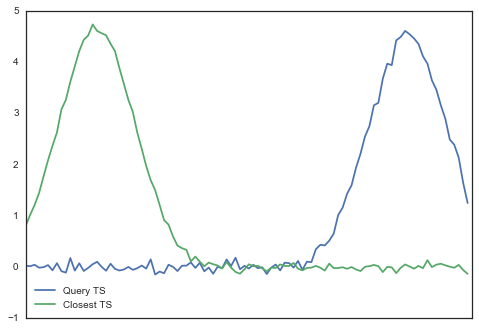

In [43]:
# visualize the results
plt.plot(query, label='Query TS')
plt.plot(tsdict[list(results.keys())[0]], label='Closest TS')
plt.legend(loc='best')
plt.xticks([])
plt.show()

### iSAX Tree Similarity Search

Runs an iSAX tree-based similarity search, which returns a faster but only returns an approximate result.

**Function signature:**

`isax_similarity_search(query)`

`Parameters`  
`----------`  
`query : TimeSeries`  
`The time series being compared to those in the database`  

`Returns`  
`-------`  
`Primary key of the closest time series (or error message if database operation fails).`

**Examples:**

In [44]:
# run similarity search on a time series already in the database
# should return the same time series
primary_keys[0], web_interface.isax_similarity_search(tsdict[primary_keys[0]])

('ts-0', OrderedDict([('ts-47', 2.9392951166357326)]))

In [45]:
# create dummy time series for demonstration purposes
_, query = tsmaker(np.random.uniform(low=0.0, high=1.0),
                   np.random.uniform(low=0.05, high=0.4),
                   np.random.uniform(low=0.05, high=0.2))

# note: because this is an approximate search, it will not be able
# to find a match for all query time series
results = web_interface.isax_similarity_search(query)
results

OrderedDict([('ts-3', 10.611181877793923)])

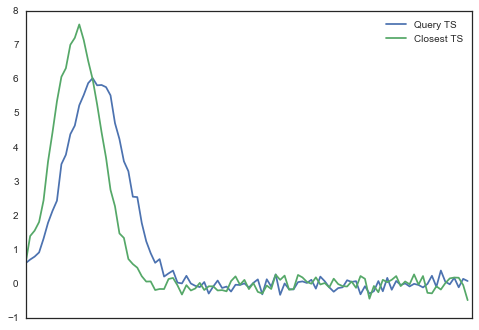

In [46]:
# visualize the results
plt.plot(query, label='Query TS')
plt.plot(tsdict[list(results.keys())[0]], label='Closest TS')
plt.legend(loc='best')
plt.xticks([])
plt.show()

### iSAX Tree Representation

Returns a visual representation of the current contents of the iSAX tree.

**Function signature:**

`isax_tree()`

`Parameters`  
`----------`  
`None`  

`Returns`  
`-------`  
`Result of the database operation (or error message).`

**Examples:**

In [47]:
# note: print() is required to visualize the tree correctly with carriage returns
print(web_interface.isax_tree())

root
--->['11', '10', '00', '01']: 4 ['ts-12', 'ts-34', 'ts-39', 'ts-47']
--->['00', '10', '10', '10']: 0 []
------>['000', '101', '101', '101']: 5 ['ts-1', 'ts-28', 'ts-3', 'ts-31', 'ts-38']
------>['000', '100', '101', '101']: 1 ['ts-17']
--->['01', '00', '01', '11']: 2 ['ts-18', 'ts-2']
--->['00', '00', '10', '11']: 3 ['ts-11', 'ts-36', 'ts-4']
--->['11', '01', '00', '01']: 1 ['ts-5']
--->['11', '10', '01', '00']: 1 ['ts-6']
--->['01', '00', '10', '11']: 2 ['ts-14', 'ts-7']
--->['11', '01', '00', '11']: 2 ['ts-19', 'ts-8']
--->['11', '11', '01', '00']: 3 ['ts-33', 'ts-42', 'ts-9']
--->['11', '00', '00', '10']: 1 ['ts-10']
--->['10', '00', '01', '11']: 4 ['ts-13', 'ts-24', 'ts-32', 'ts-48']
--->['00', '01', '10', '11']: 4 ['ts-15', 'ts-30', 'ts-35', 'ts-40']
--->['00', '01', '11', '11']: 2 ['ts-16', 'ts-46']
--->['11', '10', '00', '00']: 5 ['ts-20', 'ts-21', 'ts-22', 'ts-23', 'ts-37']
--->['00', '00', '11', '11']: 1 ['ts-25']
--->['10', '10', '00', '01']: 1 ['ts-26']
--->['11', '00',

## Termination

Let's delete all the data before closing, so that we can start again from scratch in future demonstrations.

In [48]:
# insert all the time series
for k in primary_keys:
    web_interface.delete_ts(pk=k)

In [49]:
# check that no data is left
web_interface.select()

OrderedDict()

Remember to terminate any outstanding processes!

In [50]:
# terminate processes before exiting
os.kill(server.pid, signal.SIGINT)
time.sleep(5)  # give it time to terminate
web_interface = None
webserver.terminate()